imports + configs globales

In [1]:
import os, glob, warnings, sys, platform, multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
import importlib  

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import clone

from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import src.death_classifier_helpers as helpers
importlib.reload(helpers)

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.dpi"] = 120



Reproducibility & environment (sans doublons)

In [2]:
print("=== Reproducibility ===")
print("Python version   :", sys.version.split()[0])
print("Platform         :", platform.platform())
print("CPU cores        :", multiprocessing.cpu_count())
print("NumPy version    :", np.__version__)
print("scikit-learn ver :", sklearn.__version__)
print("XGBoost version  :", xgb.__version__)
print("Random seed      :", RANDOM_STATE)


=== Reproducibility ===
Python version   : 3.10.18
Platform         : macOS-11.3.1-arm64-arm-64bit
CPU cores        : 8
NumPy version    : 1.26.4
scikit-learn ver : 1.6.1
XGBoost version  : 3.1.2
Random seed      : 42


Paramètres d’expérience

In [3]:
SEGMENTS_DIR = "preprocessed_data/segments"
RAW_SIGNAL_COLS_CANDIDATES = ["Speed", "turning_angle"]  # pas X,Y
NEAR_DEATH_N_SEGMENTS = 20
TARGET_LEN = 900

USE_SMALL_SUBSET = False
SMALL_SUBSET_SIZE = 3000
MAX_FILES = None


Vérification fichiers + colonnes

In [4]:
files = glob.glob(os.path.join(SEGMENTS_DIR, "*.csv"))
if MAX_FILES is not None:
    files = files[:MAX_FILES]

print(f"Found {len(files)} segment files in {SEGMENTS_DIR}")
if len(files) == 0:
    raise RuntimeError("No segment CSV found. Check SEGMENTS_DIR path.")

df_ex = pd.read_csv(files[0])
print("Example file:", os.path.basename(files[0]))
print("Columns:", df_ex.columns.tolist())

raw_cols = [c for c in RAW_SIGNAL_COLS_CANDIDATES if c in df_ex.columns]
if len(raw_cols) == 0:
    raise RuntimeError(f"None of {RAW_SIGNAL_COLS_CANDIDATES} found in segment CSV columns.")

print("Using raw signal columns:", raw_cols)


Found 8150 segment files in preprocessed_data/segments
Example file: coordinates_highestspeed_20250205_9_3_with_time_speed-fragment4.0-preprocessed.csv
Columns: ['GlobalFrame', 'Timestamp', 'Speed', 'X', 'Y', 'condition', 'source_file', 'Segment_index', 'turning_angle', 'worm_id', 'Segment']
Using raw signal columns: ['Speed', 'turning_angle']


Loader robuste (padding/troncature) + métadonnées

In [5]:
X_raw, worm_ids, segment_indices, info = helpers.load_segments_featureless(files, raw_cols, target_len=TARGET_LEN)
print("Load info:", info)
print("X_raw shape:", X_raw.shape, "(N,T,C)")
print("Unique worms:", len(np.unique(worm_ids)))

Load info: {'N': 8150, 'skipped': 0, 'min_len': 2, 'max_len': 901, 'n_worms': 104}
X_raw shape: (8150, 900, 2) (N,T,C)
Unique worms: 104


Labels near-death (derniers N segments, sans lifespan externe)

In [6]:
'''segments_from_end = np.zeros_like(segment_indices, dtype=int)

for wid in np.unique(worm_ids):
    mask = (worm_ids == wid)
    idxs = segment_indices[mask]
    max_seg = idxs.max()
    segments_from_end[mask] = max_seg - idxs

y = (segments_from_end <= NEAR_DEATH_N_SEGMENTS).astype(int)
'''
segments_from_end = helpers.compute_segments_from_end(worm_ids, segment_indices)
y = helpers.make_y_near_death(segments_from_end, NEAR_DEATH_N_SEGMENTS)

print("Label distribution (0=far, 1=near):", np.bincount(y))
print("Positive rate:", y.mean())


Label distribution (0=far, 1=near): [6016 2134]
Positive rate: 0.261840490797546


Flatten + subset optionnel + groups

In [7]:
N, T, C = X_raw.shape
X_flat = X_raw.reshape(N, T * C)
groups = worm_ids

if USE_SMALL_SUBSET:
    n = min(SMALL_SUBSET_SIZE, N)
    idx_sub = np.random.choice(N, size=n, replace=False)
    X_used = X_flat[idx_sub]
    y_used = y[idx_sub]
    groups_used = groups[idx_sub]
    print("Using subset:", X_used.shape, np.bincount(y_used))
else:
    X_used, y_used, groups_used = X_flat, y, groups
    print("Using full data:", X_used.shape, np.bincount(y_used))

print("n_worms:", len(np.unique(groups_used)))


Using full data: (8150, 1800) [6016 2134]
n_worms: 104


Dummy baseline (grouped CV)

In [8]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, aucs = [], [], []
for tr, te in cv.split(X_used, y_used, groups=groups_used):
    dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
    dummy.fit(X_used[tr], y_used[tr])
    proba = dummy.predict_proba(X_used[te])[:, 1]
    pred = (proba >= 0.5).astype(int)
    accs.append(accuracy_score(y_used[te], pred))
    f1s.append(f1_score(y_used[te], pred))
    if len(np.unique(y_used[te])) == 2:
        aucs.append(roc_auc_score(y_used[te], proba))
    else:
        aucs.append(np.nan)


print("=== Dummy (stratified) grouped CV ===")
print(f"ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1 : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


=== Dummy (stratified) grouped CV ===
ACC: 0.618 ± 0.008
F1 : 0.274 ± 0.016
AUC: 0.508 ± 0.008


Modèles (model zoo)

In [9]:
models = {}

models["LogReg_l2"] = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

models["HistGB"] = HistGradientBoostingClassifier(
    learning_rate=0.1, max_depth=3, max_iter=300,
    class_weight="balanced", random_state=RANDOM_STATE
)

models["RandomForest"] = RandomForestClassifier(
    n_estimators=600, min_samples_leaf=2,
    class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)

models["ExtraTrees"] = ExtraTreesClassifier(
    n_estimators=800, min_samples_leaf=2,
    class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)

models["SVM_RBF_PCA100"] = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=100, random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced",
               probability=True, random_state=RANDOM_STATE))
])

models["XGBoost"] = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=RANDOM_STATE
)


Run model zoo + table

In [10]:
rows = []
for name, model in models.items():
    print("\n====", name, "====")
    res = helpers.grouped_cv_eval(model, X_used, y_used, groups_used, n_splits=5)
    rows.append({"model": name, **res})
    print(f"F1={res['F1_mean']:.3f}±{res['F1_std']:.3f} | AUC={res['AUC_mean']:.3f}±{res['AUC_std']:.3f} | ACC={res['ACC_mean']:.3f}±{res['ACC_std']:.3f} | fit={res['fit_s_mean']:.1f}s")

zoo_df = pd.DataFrame(rows).sort_values("F1_mean", ascending=False)
display(zoo_df)



==== LogReg_l2 ====


F1=0.494±0.033 | AUC=0.725±0.016 | ACC=0.689±0.016 | fit=2.7s

==== HistGB ====
F1=0.616±0.035 | AUC=0.836±0.014 | ACC=0.770±0.019 | fit=4.5s

==== RandomForest ====
F1=0.550±0.026 | AUC=0.847±0.019 | ACC=0.788±0.011 | fit=148.7s

==== ExtraTrees ====
F1=0.561±0.027 | AUC=0.848±0.018 | ACC=0.789±0.013 | fit=29.1s

==== SVM_RBF_PCA100 ====
F1=0.599±0.022 | AUC=0.821±0.018 | ACC=0.775±0.016 | fit=8.1s

==== XGBoost ====
F1=0.559±0.023 | AUC=0.844±0.013 | ACC=0.789±0.006 | fit=187.2s


,model,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std,fit_s_mean
1,HistGB,0.769809,0.019453,0.616389,0.035262,0.836000,0.013764,4.486354
4,SVM_RBF_PCA100,0.775033,0.015937,0.598552,0.022467,0.821186,0.018284,8.124517
3,ExtraTrees,0.789040,0.012728,0.560534,0.027436,0.847611,0.017845,29.094335
5,XGBoost,0.788989,0.005848,0.559449,0.022786,0.843697,0.013397,187.155292
2,RandomForest,0.787987,0.010941,0.549643,0.026490,0.847326,0.018556,148.724082
0,LogReg_l2,0.688698,0.016460,0.494033,0.032608,0.724695,0.016265,2.702911


“À hyperparamètres raisonnables par défaut, quel type de modèle est prometteur ?” -> HistGB 

Split Train/Val/Test groupé (worm-level)

In [11]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
train_idx, temp_idx = next(gss1.split(X_used, y_used, groups=groups_used))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE + 1)
val_idx_temp, test_idx_temp = next(gss2.split(
    X_used[temp_idx], y_used[temp_idx], groups=groups_used[temp_idx]
))
val_idx = temp_idx[val_idx_temp]
test_idx = temp_idx[test_idx_temp]

X_train, y_train, g_train = X_used[train_idx], y_used[train_idx], groups_used[train_idx]
X_val,   y_val,   g_val   = X_used[val_idx],   y_used[val_idx],   groups_used[val_idx]
X_test,  y_test,  g_test  = X_used[test_idx],  y_used[test_idx],  groups_used[test_idx]

print("Train:", X_train.shape, np.bincount(y_train))
print("Val  :", X_val.shape,   np.bincount(y_val))
print("Test :", X_test.shape,  np.bincount(y_test))


Train: (5743, 1800) [4261 1482]
Val  : (1301, 1800) [981 320]
Test : (1106, 1800) [774 332]


In [12]:
assert len(set(g_train) & set(g_val)) == 0
assert len(set(g_train) & set(g_test)) == 0
assert len(set(g_val) & set(g_test)) == 0


CV interne (tuning)

In [13]:
cv_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


Modèles à tuner + espaces de recherche:
Each candidate model was first independently tuned using grouped cross-validation on the training set. Model selection and decision threshold optimization were then performed on a held-out validation set, and final performance was reported on an unseen test set.

In [14]:
histgb = HistGradientBoostingClassifier(class_weight="balanced", random_state=RANDOM_STATE)
histgb_params = {
    "learning_rate": [0.02, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 6, None],
    "max_iter": [200, 400, 800],
    "l2_regularization": [0.0, 0.1, 1.0, 5.0],
    "min_samples_leaf": [10, 20, 50, 100],
}

extratrees = ExtraTreesClassifier(class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)
extratrees_params = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [None, 10, 20, 40],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", 0.2, 0.5, 1.0],
}

svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE))
])
svm_params = {
    "pca__n_components": [50, 100, 200, 300],
    "svm__C": [0.5, 1, 3, 10, 30],
    "svm__gamma": ["scale", 1e-2, 1e-3, 3e-4],
}

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)
xgb_params = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "min_child_weight": [1, 5, 10],
}


Run tunings + table

In [15]:
results = {}

results["HistGB"] = helpers.tune_model(
    "HistGB", histgb, histgb_params,
    X_train, y_train, g_train,
    cv_inner, n_iter=30, random_state=RANDOM_STATE
)

results["ExtraTrees"] = helpers.tune_model(
    "ExtraTrees", extratrees, extratrees_params,
    X_train, y_train, g_train,
    cv_inner, n_iter=30, random_state=RANDOM_STATE
)

results["SVM_RBF_PCA"] = helpers.tune_model(
    "SVM_RBF_PCA", svm_rbf, svm_params,
    X_train, y_train, g_train,
    cv_inner, n_iter=25, random_state=RANDOM_STATE
)

results["XGBoost"] = helpers.tune_model(
    "XGBoost", xgb_model, xgb_params,
    X_train, y_train, g_train,
    cv_inner, n_iter=30, random_state=RANDOM_STATE
)

rows = []
for name, (search, best, best_params, best_cv_f1, dt) in results.items():
    rows.append({"model": name, "best_cv_F1": best_cv_f1, "time_min": dt / 60})

tuning_df = pd.DataFrame(rows).sort_values("best_cv_F1", ascending=False)
display(tuning_df)


Fitting 5 folds for each of 30 candidates, totalling 150 fits



=== HistGB DONE ===
Best CV F1: 0.6175
Best params: {'min_samples_leaf': 50, 'max_iter': 200, 'max_depth': 2, 'learning_rate': 0.05, 'l2_regularization': 1.0}
Time: 55.0 min
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== ExtraTrees DONE ===
Best CV F1: 0.6255
Best params: {'n_estimators': 400, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None}
Time: 483.3 min
Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== SVM_RBF_PCA DONE ===
Best CV F1: 0.6163
Best params: {'svm__gamma': 'scale', 'svm__C': 3, 'pca__n_components': 100}
Time: 38.4 min
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== XGBoost DONE ===
Best CV F1: 0.5426
Best params: {'subsample': 0.7, 'reg_lambda': 5.0, 'n_estimators': 1200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.02, 'colsample_bytree': 0.8}
Time: 95.2 min


,model,best_cv_F1,time_min
1,ExtraTrees,0.625466,483.316015
0,HistGB,0.617543,54.963111
2,SVM_RBF_PCA,0.616270,38.412485
3,XGBoost,0.542616,95.218959


ce tableau rpz F1 moyenne sur CV interne, uniquement sur le TRAIN, pendant le renadomized searchCV avec un threshold implicit a 0,5

Validation eval @0.5

In [16]:
def eval_on_split(model, X, y, thr=0.5):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= thr).astype(int)
    return {
        "ACC": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "AUC": roc_auc_score(y, proba),
        "proba": proba,
        "pred": pred
    }

val_rows = []
for name, (_, best, _, _, _) in results.items():
    out = eval_on_split(best, X_val, y_val, thr=0.5)
    val_rows.append({"model": name, "val_ACC@0.5": out["ACC"], "val_F1@0.5": out["F1"], "val_AUC": out["AUC"]})

val_df = pd.DataFrame(val_rows).sort_values("val_F1@0.5", ascending=False)
display(val_df)


,model,val_ACC@0.5,val_F1@0.5,val_AUC
0,HistGB,0.754804,0.636260,0.849509
1,ExtraTrees,0.764796,0.635714,0.856299
2,SVM_RBF_PCA,0.771714,0.584615,0.833595
3,XGBoost,0.784781,0.536424,0.856306


repond a la question “À seuil standard (0.5), quel modèle optimisé se comporte le mieux ?”
F1 sur le jeu de validation, modele deja tune et entraine sur le train 
Val F1 = un seul split 

Threshold tuning sur VAL (par modèle) + table

In [17]:
print("Note: decision threshold is tuned on validation for each tuned model; final selection uses the best validation F1.")

thr_summary, thr_curves = [], {}
for name, (_, best, _, _, _) in results.items():
    thr, f1best, curve = helpers.tune_threshold(best, X_val, y_val)
    thr_summary.append({"model": name, "best_thr_val": thr, "best_val_F1": f1best})
    thr_curves[name] = curve

thr_df = pd.DataFrame(thr_summary).sort_values("best_val_F1", ascending=False)
display(thr_df)


Note: decision threshold is tuned on validation for each tuned model; final selection uses the best validation F1.


,model,best_thr_val,best_val_F1
3,XGBoost,0.25,0.641638
2,SVM_RBF_PCA,0.30,0.640182
1,ExtraTrees,0.45,0.639731
0,HistGB,0.45,0.638251


“Model selection was performed in two stages: first by hyperparameter optimization using grouped cross-validation on the training set, and second by decision threshold tuning on a held-out validation set. The final champion was selected based on the best validation F1-score after threshold optimization.”

Rather than relying on a single selection criterion, we retain two complementary models. The first model is selected based on peak validation performance after full optimization (hyperparameters and decision threshold), reflecting the best achievable classification accuracy. The second model is selected based on cross-validated stability across grouped folds, favoring robustness and generalization across worms. This dual selection allows us to contrast performance-optimal and stability-oriented approaches.

Champion 1 — Best validation performance after full optimization

Performance-driven model

Critère :

meilleur F1 sur validation

après hyperparameter tuning

après threshold tuning

Typiquement : XGBoost

Champion 2 — Most stable model under grouped CV

Robustness-driven model

Critère :

meilleur F1 moyenne en grouped CV

avant split train/val/test

faible variance

Typiquement : HistGB

Robustness champion: HistGB | F1_mean: 0.6163892543272624 | F1_std: 0.035261692659077526
Champion Performance: XGBoost
Chosen threshold for performance champ (val): 0.25
Champion Robustness: HistGB
HistGB best threshold: 0.44999999999999996
HistGB best val F1: 0.6382513661202186


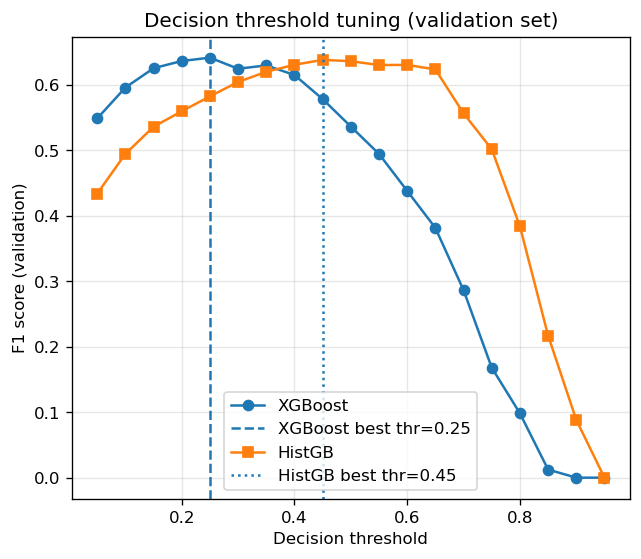

In [18]:
# Champion performance = best after threshold tuning
perf_champ_name = thr_df.iloc[0]["model"]
perf_champ_thr  = float(thr_df.iloc[0]["best_thr_val"])
perf_champ_model = results[perf_champ_name][1]

cand = zoo_df[zoo_df["model"].isin(results.keys())].copy()
cand["robust_score"] = cand["F1_mean"] - 0.5 * cand["F1_std"]
robust_row = cand.sort_values("robust_score", ascending=False).iloc[0]
robust_champ_name = robust_row["model"]
robust_champ_model = results.get(robust_champ_name, [None, models[robust_champ_name]])[1]

print("Robustness champion:", robust_champ_name, 
      "| F1_mean:", robust_row["F1_mean"], 
      "| F1_std:", robust_row["F1_std"])


print("Champion Performance:", perf_champ_name)
print("Chosen threshold for performance champ (val):", perf_champ_thr)
print("Champion Robustness:", robust_champ_name)

robust_thr, robust_f1best, robust_curve = helpers.tune_threshold(
    robust_champ_model, X_val, y_val
)

print(f"{robust_champ_name} best threshold:", robust_thr)
print(f"{robust_champ_name} best val F1:", robust_f1best)


# ============================
# Threshold tuning comparison (validation)
# ============================

plt.figure(figsize=(6,5))

# Performance champion
curve_perf = thr_curves[perf_champ_name]
plt.plot(
    curve_perf["thr"], curve_perf["F1"],
    marker="o", label=f"{perf_champ_name}"
)
plt.axvline(
    perf_champ_thr, linestyle="--",
    label=f"{perf_champ_name} best thr={perf_champ_thr:.2f}"
)

# Robustness champion
plt.plot(
    robust_curve["thr"], robust_curve["F1"],
    marker="s", label=f"{robust_champ_name}"
)
plt.axvline(
    robust_thr, linestyle=":",
    label=f"{robust_champ_name} best thr={robust_thr:.2f}"
)

plt.xlabel("Decision threshold")
plt.ylabel("F1 score (validation)")
plt.title("Decision threshold tuning (validation set)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



“Figure X compares validation F1 as a function of the decision threshold for the two selected models. While both models benefit from threshold adjustment, the performance-oriented model exhibits a sharper optimum, whereas the robustness-oriented model displays a broader plateau, indicating greater stability with respect to threshold selection.”

Refit champion sur TRAIN+VAL

In [19]:
# ============================
# Refit final models on TRAIN+VAL
# ============================

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])


perf_model_final = clone(perf_champ_model)
perf_model_final.fit(X_trainval, y_trainval)

robust_model_final = clone(robust_champ_model)
robust_model_final.fit(X_trainval, y_trainval)


HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=1.0,
                               learning_rate=0.05, max_depth=2, max_iter=200,
                               min_samples_leaf=50, random_state=42)

Test final (une fois) + Confusion matrix (counts + normalized)

In [20]:
def eval_and_print(name, model, X, y, thr):
    """
    Evaluate a trained model on a given split and print summary metrics.

    This function is intentionally notebook-level (not in helpers),
    as it performs printing and is tied to a specific evaluation split.

    Parameters
    ----------
    name : str
        Display name of the model.
    model : sklearn-compatible classifier
        Trained model implementing predict_proba().
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Ground-truth binary labels.
    thr : float
        Decision threshold.

    Returns
    -------
    out : dict
        Dictionary containing ACC, F1, AUC, predicted probabilities,
        and hard predictions.
    """
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= thr).astype(int)

    out = {
        "ACC": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "AUC": roc_auc_score(y, proba),
        "proba": proba,
        "pred": pred
    }

    print(f"\n=== TEST ({name}) ===")
    print(f"ACC={out['ACC']:.3f} | F1={out['F1']:.3f} | AUC={out['AUC']:.3f}")
    return out


In [21]:
perf_test = eval_and_print(
    perf_champ_name,
    perf_model_final,
    X_test, y_test,
    perf_champ_thr
)

robust_test = eval_and_print(
    robust_champ_name,
    robust_model_final,
    X_test, y_test,
    robust_thr
)



=== TEST (XGBoost) ===
ACC=0.774 | F1=0.684 | AUC=0.854

=== TEST (HistGB) ===
ACC=0.768 | F1=0.677 | AUC=0.854


confusion matrices-sode by side

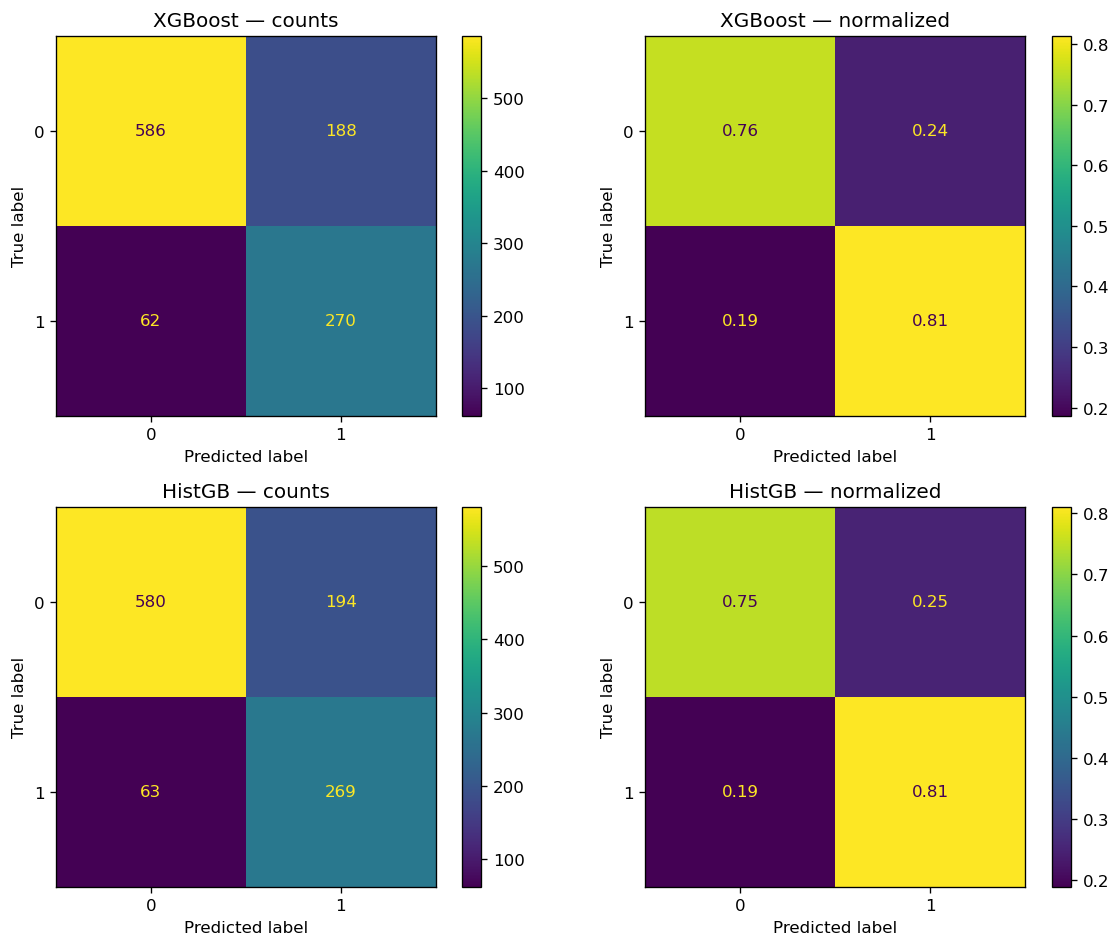

In [22]:
# ============================
# Confusion matrices comparison
# ============================

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i, (name, out, thr) in enumerate([
    (perf_champ_name, perf_test, perf_champ_thr),
    (robust_champ_name, robust_test, robust_thr),
]):
    cm = confusion_matrix(y_test, out["pred"])
    cm_norm = confusion_matrix(y_test, out["pred"], normalize="true")

    ConfusionMatrixDisplay(cm).plot(ax=ax[i,0], values_format="d")
    ax[i,0].set_title(f"{name} — counts")

    ConfusionMatrixDisplay(cm_norm).plot(ax=ax[i,1], values_format=".2f")
    ax[i,1].set_title(f"{name} — normalized")

plt.tight_layout()
plt.show()


PR curve (AP + point du threshold) — version corrigée

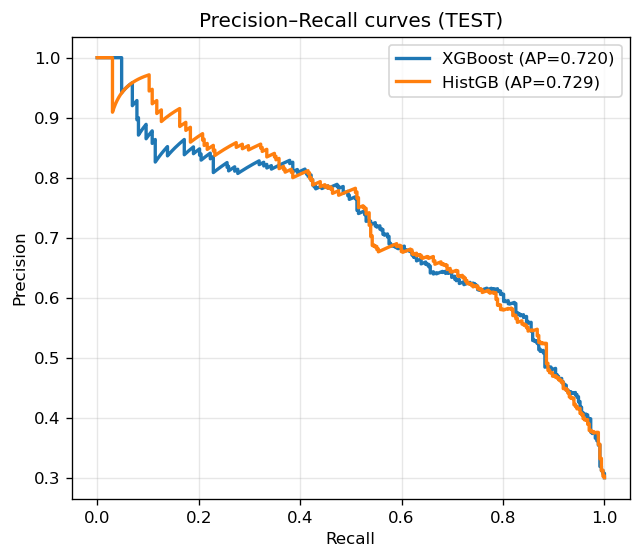

In [23]:
# ============================
# Precision–Recall curves
# ============================

plt.figure(figsize=(6,5))

for name, out in [
    (perf_champ_name, perf_test),
    (robust_champ_name, robust_test),
]:
    precision, recall, _ = precision_recall_curve(y_test, out["proba"])
    ap = average_precision_score(y_test, out["proba"])
    plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (TEST)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


CV final champion (mean ± std) avec threshold fixé

“To assess stability, we report grouped 5-fold cross-validation performance on the training set, using fixed decision thresholds tuned on the validation set. Final generalization is reported on the held-out test set.”

In [24]:

# CV final sur TRAIN (pas de fuite: thresholds viennent du VAL)
print("=== Final grouped CV on TRAIN (fixed thresholds tuned on VAL) ===")

perf_cv = helpers.grouped_cv_fixed_threshold(perf_champ_model, X_train, y_train, g_train, perf_champ_thr, n_splits=5)
robust_cv = helpers.grouped_cv_fixed_threshold(robust_champ_model, X_train, y_train, g_train, robust_thr, n_splits=5)

print(f"\n{perf_champ_name} (thr={perf_champ_thr:.2f})")
print(f"ACC: {perf_cv['ACC_mean']:.3f} ± {perf_cv['ACC_std']:.3f}")
print(f"F1 : {perf_cv['F1_mean']:.3f} ± {perf_cv['F1_std']:.3f}")
print(f"AUC: {perf_cv['AUC_mean']:.3f} ± {perf_cv['AUC_std']:.3f}")

print(f"\n{robust_champ_name} (thr={robust_thr:.2f})")
print(f"ACC: {robust_cv['ACC_mean']:.3f} ± {robust_cv['ACC_std']:.3f}")
print(f"F1 : {robust_cv['F1_mean']:.3f} ± {robust_cv['F1_std']:.3f}")
print(f"AUC: {robust_cv['AUC_mean']:.3f} ± {robust_cv['AUC_std']:.3f}")



=== Final grouped CV on TRAIN (fixed thresholds tuned on VAL) ===

XGBoost (thr=0.25)
ACC: 0.755 ± 0.014
F1 : 0.619 ± 0.014
AUC: 0.834 ± 0.017

HistGB (thr=0.45)
ACC: 0.742 ± 0.012
F1 : 0.619 ± 0.015
AUC: 0.835 ± 0.017


ablation study

In [25]:


subsets = [
    [raw_cols[0]],
    [raw_cols[1]],
    raw_cols
]

rows = []
for subset in subsets:
    mean_f1, std_f1 = helpers.grouped_cv_f1_for_subset(
        perf_champ_model, X_raw, y_used, groups_used,
        raw_cols, subset,
        thr=perf_champ_thr, random_state=RANDOM_STATE
    )
    rows.append({
        "model": perf_champ_name,
        "subset": "+".join(subset),
        "F1_mean": mean_f1,
        "F1_std": std_f1
    })

    mean_f1, std_f1 = helpers.grouped_cv_f1_for_subset(
        robust_champ_model, X_raw, y_used, groups_used,
        raw_cols, subset,
        thr=robust_thr, random_state=RANDOM_STATE
    )
    rows.append({
        "model": robust_champ_name,
        "subset": "+".join(subset),
        "F1_mean": mean_f1,
        "F1_std": std_f1
    })

ablation_df = pd.DataFrame(rows).sort_values(["model", "F1_mean"], ascending=[True, False])
display(ablation_df)


,model,subset,F1_mean,F1_std
5,HistGB,Speed+turning_angle,0.637143,0.040145
1,HistGB,Speed,0.634861,0.040046
3,HistGB,turning_angle,0.514663,0.031327
4,XGBoost,Speed+turning_angle,0.639047,0.041768
0,XGBoost,Speed,0.636716,0.040741
2,XGBoost,turning_angle,0.537327,0.042256


Proximity threshold sweep (réutilise segments_from_end)

“We evaluate the sensitivity of near-death classification to the definition of proximity by varying the number of last segments considered as positive. While the performance-oriented model achieves higher peak F1 scores, the robustness-oriented model exhibits more stable performance across a wide range of proximity thresholds, highlighting a trade-off between peak accuracy and robustness to label definition.”


=== XGBoost ===
N= 5 | pos=0.075 | F1=0.220±0.047 | AUC=0.821±0.028
N=10 | pos=0.138 | F1=0.450±0.043 | AUC=0.842±0.019
N=15 | pos=0.200 | F1=0.570±0.033 | AUC=0.844±0.006
N=20 | pos=0.262 | F1=0.639±0.042 | AUC=0.844±0.015
N=25 | pos=0.324 | F1=0.689±0.020 | AUC=0.847±0.010
N=30 | pos=0.388 | F1=0.720±0.035 | AUC=0.840±0.021
N=40 | pos=0.513 | F1=0.764±0.016 | AUC=0.829±0.010

=== HistGB ===
N= 5 | pos=0.075 | F1=0.302±0.031 | AUC=0.817±0.031
N=10 | pos=0.138 | F1=0.462±0.022 | AUC=0.845±0.017
N=15 | pos=0.200 | F1=0.561±0.017 | AUC=0.842±0.008
N=20 | pos=0.262 | F1=0.637±0.040 | AUC=0.844±0.016
N=25 | pos=0.324 | F1=0.689±0.019 | AUC=0.845±0.010
N=30 | pos=0.388 | F1=0.724±0.036 | AUC=0.841±0.020
N=40 | pos=0.513 | F1=0.765±0.013 | AUC=0.828±0.011


,model,N_last,pos_rate,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std
0,XGBoost,5,0.075460,0.907724,0.006594,0.219994,0.046592,0.821383,0.028023
1,XGBoost,10,0.138037,0.818950,0.009477,0.449953,0.043341,0.841818,0.018745
2,XGBoost,15,0.199632,0.780748,0.014199,0.569609,0.032891,0.844086,0.005717
3,XGBoost,20,0.261840,0.758522,0.025917,0.639047,0.041768,0.844061,0.014552
4,XGBoost,25,0.324294,0.750048,0.016075,0.688572,0.019920,0.847370,0.009857
5,XGBoost,30,0.387607,0.738990,0.030961,0.720069,0.035187,0.840368,0.020617
6,XGBoost,40,0.513374,0.713147,0.017498,0.763649,0.016395,0.828823,0.010499
7,HistGB,5,0.075460,0.722632,0.017987,0.302350,0.030937,0.817166,0.030761
8,HistGB,10,0.138037,0.729733,0.013118,0.461993,0.021664,0.845036,0.017292
9,HistGB,15,0.199632,0.736811,0.012367,0.560638,0.017123,0.842116,0.007564


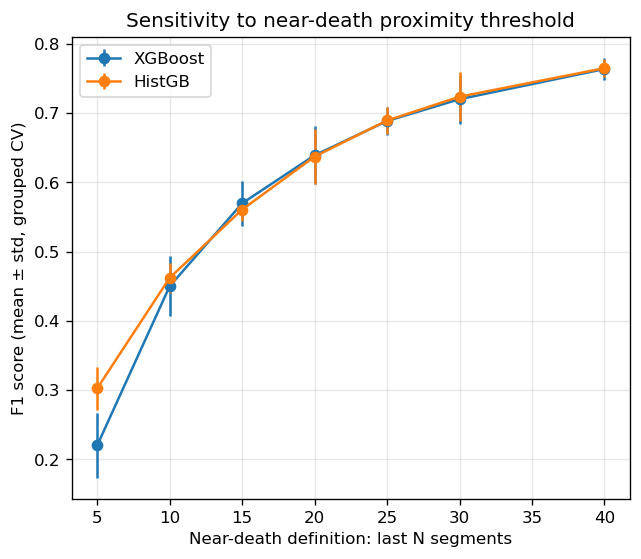

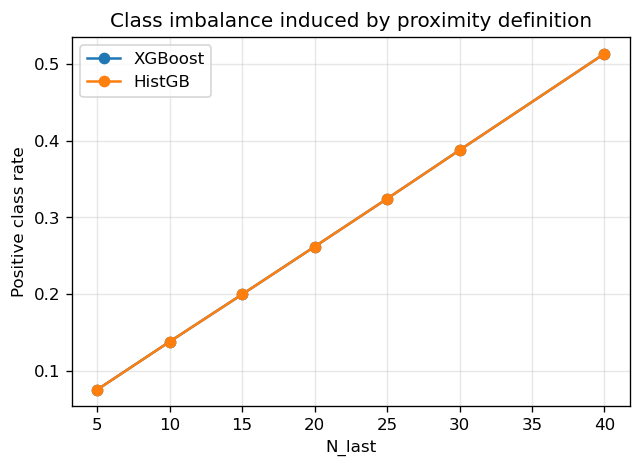

In [26]:

# ============================
# Proximity threshold sweep (two champions)
# ============================

N_list = [5, 10, 15, 20, 25, 30, 40]

rows = []

for name, model, thr in [
    (perf_champ_name, perf_champ_model, perf_champ_thr),
    (robust_champ_name, robust_champ_model, robust_thr),
]:
    print(f"\n=== {name} ===")
    for N_last in N_list:
        res = helpers.cv_eval_for_N(
            model,
            X_flat,
            segments_from_end,
            worm_ids,
            N_last,
            thr=thr,
            n_splits=5
        )
        rows.append({
            "model": name,
            "N_last": N_last,
            **res
        })
        print(
            f"N={N_last:>2} | pos={res['pos_rate']:.3f} | "
            f"F1={res['F1_mean']:.3f}±{res['F1_std']:.3f} | "
            f"AUC={res['AUC_mean']:.3f}±{res['AUC_std']:.3f}"
        )

nearN_df = pd.DataFrame(rows)
display(nearN_df)

# ============================
# F1 vs proximity threshold (N_last)
# ============================

plt.figure(figsize=(6,5))

for name in nearN_df["model"].unique():
    sub = nearN_df[nearN_df["model"] == name]
    plt.errorbar(
        sub["N_last"],
        sub["F1_mean"],
        yerr=sub["F1_std"],
        marker="o",
        label=name
    )

plt.xlabel("Near-death definition: last N segments")
plt.ylabel("F1 score (mean ± std, grouped CV)")
plt.title("Sensitivity to near-death proximity threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ============================
# Positive class rate vs N_last
# ============================

plt.figure(figsize=(6,4))

for name in nearN_df["model"].unique():
    sub = nearN_df[nearN_df["model"] == name]
    plt.plot(
        sub["N_last"],
        sub["pos_rate"],
        marker="o",
        label=name
    )

plt.xlabel("N_last")
plt.ylabel("Positive class rate")
plt.title("Class imbalance induced by proximity definition")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


life-stage analysis

In [27]:


def stage_from_norm_age(a):
    if a < 0.25: return "early"
    if a < 0.50: return "mid"
    if a < 0.75: return "late"
    return "very_late"

norm_age_all = helpers.compute_normalized_age(worm_ids, segment_indices)
stages_all = np.array([stage_from_norm_age(a) for a in norm_age_all])

print(pd.Series(stages_all).value_counts())


early        2058
very_late    2046
mid          2029
late         2017
Name: count, dtype: int64


Métriques par stage (mean±std): 

,stage,n_mean,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std,model
4,early,411.6,0.906419,0.017912,0.000000,0.000000,NaN,NaN,HistGB
5,mid,405.8,0.827565,0.032864,0.000000,0.000000,0.517526,0.053526,HistGB
6,late,403.4,0.447508,0.095564,0.205887,0.091611,0.485075,0.068091,HistGB
7,very_late,409.2,0.813345,0.032431,0.895874,0.019715,0.634675,0.077684,HistGB
0,early,411.6,0.912888,0.021682,0.000000,0.000000,NaN,NaN,XGBoost
1,mid,405.8,0.841607,0.020424,0.000000,0.000000,0.535965,0.069298,XGBoost
2,late,403.4,0.472254,0.090683,0.201159,0.094572,0.488603,0.067855,XGBoost
3,very_late,409.2,0.802400,0.040324,0.888177,0.025343,0.622738,0.050713,XGBoost


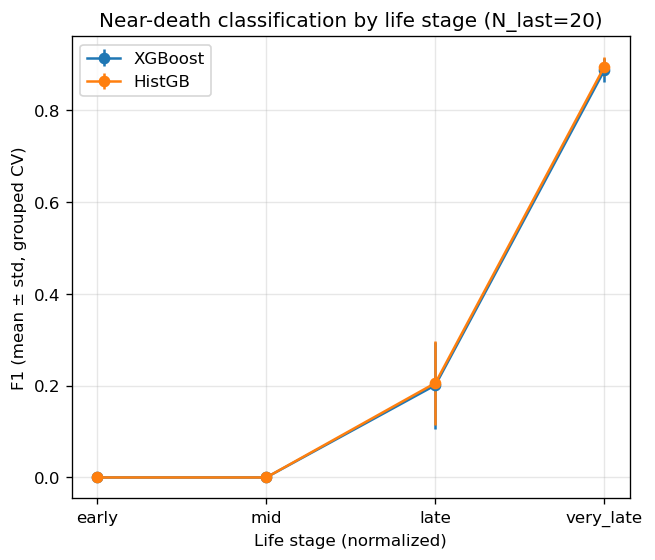

F1_mean              F1_std          
model        HistGB   XGBoost    HistGB   XGBoost
stage                                            
early      0.000000  0.000000  0.000000  0.000000
mid        0.000000  0.000000  0.000000  0.000000
late       0.205887  0.201159  0.091611  0.094572
very_late  0.895874  0.888177  0.019715  0.025343

,stage,n_samples,n_positive,positive_rate
0,early,2058,0,0.000000
2,mid,2029,2,0.000986
1,late,2017,253,0.125434
3,very_late,2046,1879,0.918377


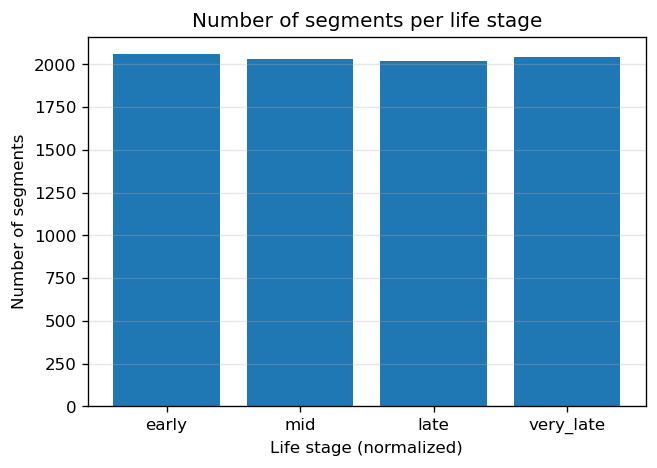

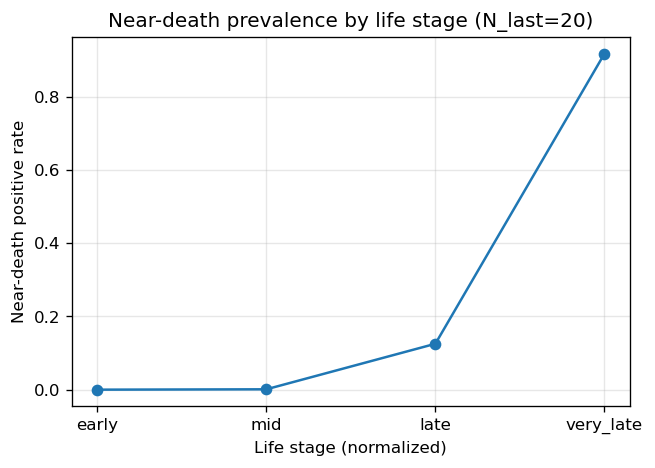

In [28]:
# ============================
# Life-stage analysis (two champions)
# ============================

N_for_stage = 20
y_stage = helpers.make_y_near_death(segments_from_end, N_for_stage)

order = ["early", "mid", "late", "very_late"]

all_rows = []

for name, model, thr in [
    (perf_champ_name, perf_champ_model, perf_champ_thr),
    (robust_champ_name, robust_champ_model, robust_thr),
]:
    df_stage = helpers.stage_metrics_grouped_cv(
        model,
        X_flat,
        y_stage,
        worm_ids,
        stages_all,
        thr=thr,
        n_splits=5
    )

    df_stage["model"] = name
    df_stage["stage"] = pd.Categorical(df_stage["stage"], categories=order, ordered=True)
    df_stage = df_stage.sort_values("stage")

    all_rows.append(df_stage)

stage_df_all = pd.concat(all_rows, ignore_index=True)
display(stage_df_all.sort_values(["model", "stage"]))

# ============================
# Plot: F1 by life stage (two champions)
# ============================

plt.figure(figsize=(6,5))

for name in stage_df_all["model"].unique():
    sub = stage_df_all[stage_df_all["model"] == name].sort_values("stage")

    plt.errorbar(
        sub["stage"].astype(str),
        sub["F1_mean"],
        yerr=sub["F1_std"],
        marker="o",
        label=name
    )

plt.xlabel("Life stage (normalized)")
plt.ylabel("F1 (mean ± std, grouped CV)")
plt.title(f"Near-death classification by life stage (N_last={N_for_stage})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ============================
# Pivot table for report (optional)
# ============================

pivot_stage = stage_df_all.pivot_table(
    index="stage",
    columns="model",
    values=["F1_mean", "F1_std"],
    aggfunc="first"
)

display(pivot_stage)

# ============================
# Number of samples per life stage
# ============================

stage_counts = (
    pd.DataFrame({
        "stage": stages_all,
        "y": y_stage
    })
    .groupby("stage")
    .agg(
        n_samples=("y", "size"),
        n_positive=("y", "sum"),
        positive_rate=("y", "mean")
    )
    .reset_index()
)

# Ordre explicite
order = ["early", "mid", "late", "very_late"]
stage_counts["stage"] = pd.Categorical(stage_counts["stage"], categories=order, ordered=True)
stage_counts = stage_counts.sort_values("stage")

display(stage_counts)

# ============================
# Plot: number of segments per life stage
# ============================

plt.figure(figsize=(6,4))
plt.bar(stage_counts["stage"].astype(str), stage_counts["n_samples"])
plt.xlabel("Life stage (normalized)")
plt.ylabel("Number of segments")
plt.title("Number of segments per life stage")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# ============================
# Plot: near-death rate per life stage
# ============================

plt.figure(figsize=(6,4))
plt.plot(
    stage_counts["stage"].astype(str),
    stage_counts["positive_rate"],
    marker="o"
)
plt.xlabel("Life stage (normalized)")
plt.ylabel("Near-death positive rate")
plt.title(f"Near-death prevalence by life stage (N_last={N_for_stage})")
plt.grid(True, alpha=0.3)
plt.show()


Performance varies across life stages, with higher F1-scores observed in later stages of life. This effect is partly explained by the increasing prevalence of near-death segments as worms approach the end of their lifespan. Early-life stages exhibit both a lower positive class rate and a smaller absolute number of informative samples, leading to higher variance and reduced classification performance. These results highlight that near-death classification is intrinsically easier closer to death, where behavioral signals become more distinctive.